# Runner example

This notebook will go through the options of the runner class. We will show how to fit and evaluate a model in parallel, and how to do cross-validation. 

We will also demonstrate how to transfer and extend a HBR model using the runner.


### Imports

In [1]:
import pandas as pd
import os
from pcntoolkit.dataio.norm_data import NormData
from pcntoolkit.normative_model.norm_conf import NormConf
from pcntoolkit.normative_model.norm_blr import NormBLR
from pcntoolkit.regression_model.blr.blr_conf import BLRConf
from pcntoolkit.normative_model.norm_hbr import NormHBR
from pcntoolkit.regression_model.hbr.hbr_conf import HBRConf

from pcntoolkit.util.runner import Runner
from pcntoolkit.util.plotter import plot_centiles, plot_qq

os.makedirs("resources/data", exist_ok=True)

# Load data

First we download a small example dataset from github. Saving this dataset on your local device (under 'resources/data/fcon1000.csv' for example) saves time and bandwidth if you re-run this notebook.

In [2]:
# If you are running this notebook for the first time, you need to download the dataset from github.
# If you have already downloaded the dataset, you can comment out the following line

pd.read_csv(
    "https://raw.githubusercontent.com/predictive-clinical-neuroscience/PCNtoolkit-demo/refs/heads/main/data/fcon1000.csv"
).to_csv("resources/data/fcon1000.csv", index=False)
data = pd.read_csv("resources/data/fcon1000.csv")
covariates = ["age"]
batch_effects = ["sex", "site"]
response_vars = ["rh_MeanThickness_thickness", "WM-hypointensities"]
norm_data = NormData.from_dataframe(
    name="full",
    dataframe=data,
    covariates=["age"],
    batch_effects=["sex", "site"],
    response_vars=["rh_MeanThickness_thickness", "WM-hypointensities"],
)

# Leave two sites out for doing transfer and extend later
transfer_sites = ["Milwaukee_b", "Oulu"]
transfer_data, fit_data = norm_data.split_batch_effects({"site": transfer_sites}, names=("transfer", "fit"))

# Split into train and test sets
train, test = fit_data.train_test_split()
transfer_train, transfer_test = transfer_data.train_test_split()

## Configure the normative model

The normative model will be configured using a `NormConf` object, containing save and log paths and the preprocessing configurations, and a `RegConf` object, specific to the regression model type. 

Our `NormConf` object configures:
- a save path paths and whether to save the model and results
- a standardization step for both the covariates (inscaler) and the response vars (outscaler)
- a Bspline basis expansion of order 3 with 5 knots

In [3]:
# Create a NormConf object
norm_conf = NormConf(
    savemodel=True,
    saveresults=True,
    save_dir="resources/blr/save_dir",
    inscaler="standardize",
    outscaler="standardize",
    basis_function="bspline",
    basis_function_kwargs={"order": 3, "nknots": 5},
)

Process: 81940 - Configuration of normative model is valid.


## Configure the regression model


In [4]:
blr_conf = BLRConf(
    optimizer="l-bfgs-b",
    n_iter=200,
    heteroskedastic=True,
    intercept=True,
    random_intercept=False,
    random_intercept_var=False,
    warp="WarpSinhArcsinh",
    warp_reparam=True,
)

Process: 81940 - Configuration of regression model is valid.


## Combine normative and blr conf in normative model
We can either use the NormBLR constructor, or the factory method to create a normative BLR model

In [5]:
# Using the constructor
new_model = NormBLR(norm_conf=norm_conf, reg_conf=blr_conf)

## Fit the model
Normally we would just call 'fit_predict' on the model directly, but because we want to use the runner to do cross-validation in parallel, we need to first create a runner object. 

In [6]:
runner = Runner(
    cross_validate=False,
    cv_folds=3,
    parallelize=True,
    job_type="local",  # or "slurm" if you are on a slurm cluster
    n_jobs=2,
    log_dir="resources/runner_output/log_dir",
    temp_dir="resources/runner_output/temp_dir",
)
# Local parallelization might not work on login nodes due to resource restrictions

Process: 81940 - No python path specified. Using interpreter path of current process: /opt/anaconda3/envs/dev_refactor_2/bin/python


The runner object will now fit the model in parallel, and save the results in save directories that it will create for each fold.

In [7]:
runner.fit(new_model, train, observe=False)

Process: 81940 - Saving runner state to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/runner_output/temp_dir/runner_state_deea300c-f86d-4026-bb6e-2ede22e293d9.json


### Loading a fold model
We can load a model for a specific fold by calling `load_model` on the runner object. This will return a `NormBLR` object, which we can inspect and use to predict on new data.


In [8]:
fitted_model = runner.load_model()
display(fitted_model)

Process: 81940 - Configuration of normative model is valid.
Process: 81940 - Configuration of normative model is valid.
Process: 81940 - Configuration of regression model is valid.
Process: 81940 - Configuration of regression model is valid.
Process: 81940 - Configuration of regression model is valid.
Process: 81940 - Configuration of regression model is valid.


## Inspecting the model 

The norm_blr model contains a collection of regression models, one for each response variable. We can inspect those models individually by calling `norm_blr.regression_models.get("{responsevar}")`

In [9]:
single_hbr_model = fitted_model.regression_models.get("rh_MeanThickness_thickness")  # type: ignore
single_hbr_model.__dict__

{'_name': 'rh_MeanThickness_thickness',
 '_reg_conf': BLRConf(n_iter=1000, tol=1e-05, ard=False, optimizer='l-bfgs-b', l_bfgs_b_l=0.1, l_bfgs_b_epsilon=0.1, l_bfgs_b_norm='l2', intercept=False, random_intercept=True, heteroskedastic=True, intercept_var=False, random_intercept_var=True, warp='WarpSinhArcsinh', warp_reparam=True),
 'is_fitted': True,
 '_is_from_dict': True,
 'hyp': array([ 0.00275367,  0.40499485,  0.79214528,  0.34666029, -0.00341635,
        -0.08250692, -0.01156862,  0.57189289,  0.67819094, -0.0062148 ,
         0.11877658,  0.04186673, -0.03880499,  0.01406969,  0.30263215,
         0.14585986,  0.31664726,  0.05159738, -0.1665349 ,  0.09486714,
         0.07174736, -0.0141461 ,  0.17822482,  0.07423025,  0.12777867,
         0.02032843, -0.09425552,  0.00299096, -0.07749857,  0.06868653,
        -0.29133875, -0.25087432, -0.01897682, -0.08225674,  0.0140547 ,
         0.01121146, -0.00391743, -0.1026433 , -0.00478926,  0.00903358,
         0.01066819, -0.00549573, 

## Evaluation
Calling `predict` will extend the predict_data object with a number of useful arrays.
1. `measures`: DataArray, which contains a number of evaluation statistics. 
1. `zscores`: the predicted z-scores for each datapoint.  
1. `centiles`: the predicted centiles of variation evaluated at each covariate in the dataset. 


In [11]:
runner.predict(new_model, test)
# display(test.measures.to_pandas().T.round(4))

/opt/anaconda3/envs/dev_refactor_2/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/opt/anaconda3/envs/dev_refactor_2/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Configuration of normative model is valid.
Configuration of normative model is valid.
Configuration of regression model is valid.
Configuration of regression model is valid.
Configuration of regression model is valid.
Configuration of regression model is valid.
Configuration of normative model is valid.
Configuration of normative model is valid.
Configuration of regression model is valid.
Configuration of regression model is valid.
Configuration of regression model is valid.
Configuration of regression model is valid.
Process: 47486 - Predicting 1 response variables
Process: 47486 - Predicting rh_MeanThickness_thickness
Process: 47485 - Predicting 1 response variables
Process: 47485 - Predicting WM-hypointensities
Process: 47486 - Computing logp for 1 response variables
Process: 47486 - Computing logp for rh_MeanThickness_thickness
Process: 47485 - Computing logp for 1 response variables
Process: 47485 - Computing logp for WM-hypointensities
Process: 47486 - Computing zscores for 1 res

Datasets with a zscores DataArray will have the `.plot_qq()` function available:

In [27]:
display(test.zscores.to_pandas())  # the zscores

response_vars,rh_MeanThickness_thickness,WM-hypointensities
datapoints,,
515,-1.506554,-0.290508
441,-1.025062,-0.540728
1029,1.232011,1.066606
64,-2.273727,0.538423
654,0.993641,-1.938914
...,...,...
611,-1.367943,2.362957
549,-1.389841,2.429967
640,0.208957,-2.052433


In [30]:
display(test.centiles.to_dataframe().unstack(level=["response_vars", "cdf"]))

centiles                     \
response_vars rh_MeanThickness_thickness WM-hypointensities   
cdf                                 0.05               0.05   
datapoints                                                    
515                             2.470503         883.688014   
441                             2.462070        1001.447154   
1029                            2.516924         608.427493   
64                              2.380638         568.347518   
654                             2.388134         644.021266   
...                                  ...                ...   
611                             2.409486         758.976592   
549                             2.243973         720.873864   
640                             2.292612         923.560157   
648                             2.430377         736.168294   
635                             2.551923         533.294707   

                                                             \
response_vars rh_MeanThickness_thickness WM-hypointensities   
cdf                                 0.25               0.25   
datapoints                                                    
515                             2.507401        1068.627718   
441                             2.495822        1182.720133   
1029                            2.561683         820.865525   
64                              2.421003         775.677981   
654                             2.439190         976.132115   
...                                  ...                ...   
611                             2.455074        1078.151752   
549                             2.322656        1010.530705   
640                             2.368423        1335.534035   
648                             2.468552        1011.417170   
635                             2.600413         779.332451   

                                                             \
response_vars rh_MeanThickness_thickness WM-hypointensities   
cdf                                 0.50               0.50   
datapoints                                                    
515                             2.534719        1206.905243   
441                             2.520177        1321.520975   
1029                            2.597623         973.233152   
64                              2.446831         923.251693   
654                             2.471841        1230.486907   
...                                  ...                ...   
611                             2.485230        1330.983220   
549                             2.369673        1231.976686   
640                             2.413201        1725.618422   
648                             2.494640        1220.892549   
635                             2.639689         955.324673   

                                                             \
response_vars rh_MeanThickness_thickness WM-hypointensities   
cdf                                 0.75               0.75   
datapoints                                                    
515                             2.564717        1359.088596   
441                             2.546314        1477.726120   
1029                            2.638686        1134.294409   
64                              2.471668        1077.548223   
654                             2.504411        1539.873367   
...                                  ...                ...   
611                             2.516146        1649.610206   
549                             2.411255        1493.949225   
640                             2.453394        2363.847559   
648                             2.521742        1465.373810   
635                             2.684227        1142.334342   

                                                             
response_vars rh_MeanThickness_thickness WM-hypointensities  
cdf                                 0.95               0.95  
datapoints                                                   


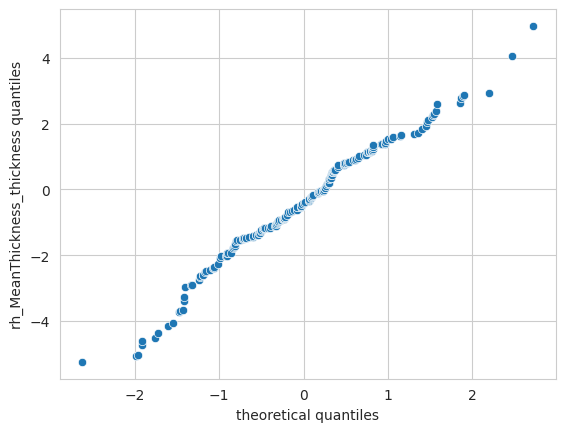

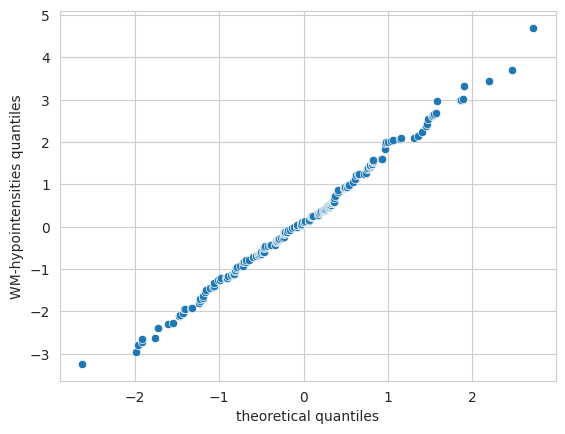

In [31]:
plot_qq(test)

And `plot_centiles()` can be called as a function of the model. A synthetic dataset is created internally, so we need to pass the original dataset (`train` in this case) as a template. We also need to pass which covariate is to be plotted on the x-axis, and the batch-effects for which the centiles are to be plotted. 

The lines correspond to the CDF values of: [0.05, 0.25, 0.5, 0.75, 0.95]. It is also possible to pass a list of CDF values to plot.

It may seem strange that the centiles do not match the plotted data, but that is because the centiles are calculated for a single batch effect, and it is superimposed on the full dataset. The blue markers correspond to the data for which the centiles are calculated. 

Computing centiles for rh_MeanThickness_thickness
Computing centiles for WM-hypointensities


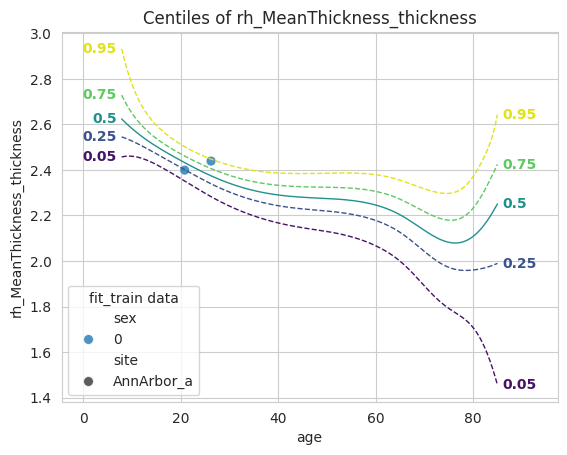

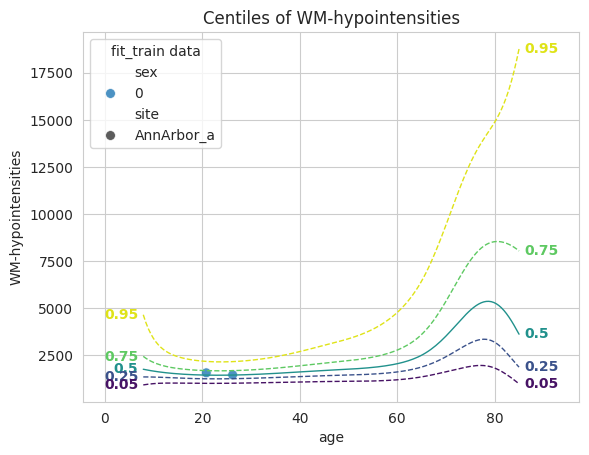

In [32]:
plot_centiles(
    fitted_model,
    train,
    covariate="age",
    show_data=True,
    hue_data="sex",
    markers_data="site",
)

The values of 0.1587 and 0.8413 correspond to a standard deviation of -1 and 1. We plot the centiles again for these values, and we also highlight a specific site. 


Computing centiles for rh_MeanThickness_thickness
Computing centiles for WM-hypointensities


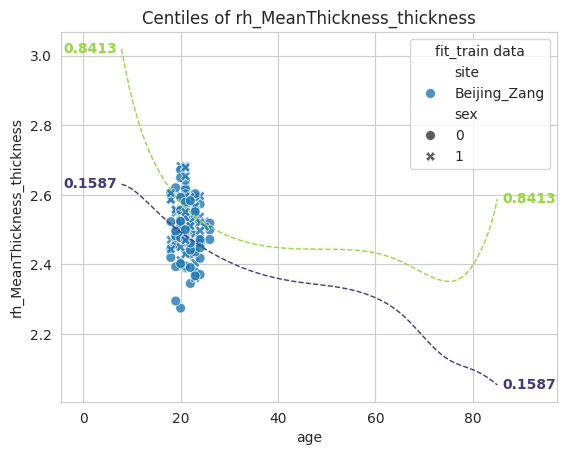

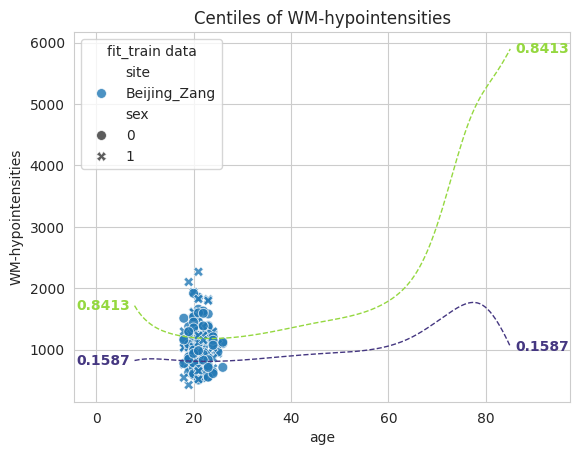

In [34]:
plot_centiles(
    fitted_model,
    train,
    covariate="age",
    centiles=[0.1587, 0.8413],
    show_data=True,
    batch_effects={"site": ["Beijing_Zang"]},
)

# Transfering with the runner

The runner can also be used to transfer or extenda model to a new dataset. This is done by calling `transfer` on the runner object. This will transfer the model to the new dataset, and save the transfered model in the save directory.

runner.transfer(transfer_train, transfer_test)

Let's first fit an HBR model, and then transfer it to the transfer dataset.



In [10]:
from pcntoolkit.regression_model.hbr.prior import make_prior


mu = make_prior(
    name="mu",
    linear=True,
    slope=make_prior(dist_name="Normal", dist_params=(0.0, 5.0)),
    intercept=make_prior(
        random=True,
        sigma=make_prior(dist_name="HalfNormal", dist_params=(1.0,)),
        mu=make_prior(dist_name="Normal", dist_params=(0.0, 0.5)),
    ),
)
sigma = make_prior(
    name="sigma",
    linear=True,
    slope=make_prior(dist_name="Normal", dist_params=(0.0, 3.0)),
    intercept=make_prior(
        dist_name="Normal",
        dist_params=(
            1.0,
            1.0,
        ),
    ),
    mapping="softplus",
    mapping_params=(0.0, 3.0),
)

# Configure the HBRConf object
hbr_conf = HBRConf(
    draws=2048,
    tune=512,
    chains=4,
    pymc_cores=16,
    likelihood="Normal",
    mu=mu,
    sigma=sigma,
    nuts_sampler="nutpie",
)
save_dir = "resources/hbr_transfer_runner/save_dir"

norm_conf = NormConf(
    savemodel=True,
    saveresults=True,
    save_dir="resources/hbr_transfer_runner/save_dir",
    inscaler="standardize",
    outscaler="standardize",
    basis_function="bspline",
    basis_function_kwargs={"order": 3, "nknots": 5},
)

new_hbr_model = NormHBR(norm_conf=norm_conf, reg_conf=hbr_conf)
runner = Runner(
    cross_validate=False,
    cv_folds=3,
    parallelize=True,
    time_limit="00:15:00",
    job_type="slurm",  # or "slurm" if you are on a slurm cluster
    n_jobs=2,
    log_dir="resources/hbr_transfer_runner/log_dir",
    temp_dir="resources/hbr_transfer_runner/temp_dir",
)
runner.fit_predict(new_hbr_model, train, test)

Job Status Monitor:
------------------------------------------------------------
Job ID     Name     State     Time     Nodes
------------------------------------------------------------

All jobs completed!


In [17]:
norm_hbr = NormHBR.load("resources/hbr_transfer_runner/save_dir")

Configuration of normative model is valid.


In [18]:
norm_hbr.predict(test)
try:
    norm_hbr.predict(transfer_test)
except Exception as e:
    print(
        f"""
≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠
The original model cannot be used to predict on the transfer dataset, because it was not trained on it

See the useful error message below:

{e}
≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠
"""
    )

Going to predict 2 models
Predicting model for rh_MeanThickness_thickness


Sampling: [y_pred]


Output()

Predicting model for WM-hypointensities


Sampling: [y_pred]


Output()

Computing zscores for rh_MeanThickness_thickness


Sampling: [y_pred]


Computing zscores for WM-hypointensities


Sampling: [y_pred]


Computing centiles for rh_MeanThickness_thickness


Sampling: [y_pred]


Computing centiles for WM-hypointensities


Sampling: [y_pred]
/opt/anaconda3/envs/dev_refactor/lib/python3.12/site-packages/pcntoolkit/util/evaluator.py:341: RuntimeWarning: invalid value encountered in log
  nll = -np.mean(y * np.log(yhat) + (1 - y) * np.log(1 - yhat))


Computing centiles for rh_MeanThickness_thickness


Sampling: [y_pred]


Computing centiles for WM-hypointensities


Sampling: [y_pred]


Results and plots saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/hbr_transfer_runner/save_dir/results and /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/hbr_transfer_runner/save_dir/plots

≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠
The original model cannot be used to predict on the transfer dataset, because it was not trained on it

See the useful error message below:

Data is not compatible with the model!
≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠



In [19]:
to_transfer = NormHBR.load("resources/hbr_transfer_runner/save_dir")
runner = Runner(
    cross_validate=False,
    parallelize=True,
    job_type="local",  # or "slurm" if you are on a slurm cluster
    n_jobs=2,
    log_dir="resources/hbr_transfer_runner/log_dir",
    temp_dir="resources/hbr_transfer_runner/temp_dir",
)
runner.transfer_predict(to_transfer, transfer_train, transfer_test)

Configuration of normative model is valid.
No python path specified. Using interpreter path of current process: /opt/anaconda3/envs/dev_refactor/bin/python
Configuration of normative model is valid.
Going to transfer 2 models
Transferring model for rh_MeanThickness_thickness
Configuration of normative model is valid.
Going to transfer 2 models
Transferring model for WM-hypointensities
Model saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/hbr_transfer_runner/save_dir_transfer/model
Going to predict 1 models
Predicting model for rh_MeanThickness_thickness
Sampling ... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:-- / 0:00:00Model saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/hbr_transfer_runner/save_dir_transfer/model
Going to predict 1 models
Predicting model for WM-hypointensities
Sampling ... ━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━  38% 0:00:01 / 0:00:00

Sampling: [y_pred]
Sampling: [y_pred]


Sampling ... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:0000:0000:00
Computing zscores for rh_MeanThickness_thickness


Sampling: [y_pred]
Sampling: [y_pred]


Sampling ... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:00/ 0:00:00
Computing zscores for WM-hypointensities
Computing centiles for rh_MeanThickness_thickness
Computing centiles for WM-hypointensities


Sampling: [y_pred]
Sampling: [y_pred]
/opt/anaconda3/envs/dev_refactor/lib/python3.12/site-packages/pcntoolkit/util/evaluator.py:232: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, _ = stats.spearmanr(y, yhat)
/opt/anaconda3/envs/dev_refactor/lib/python3.12/site-packages/pcntoolkit/util/evaluator.py:341: RuntimeWarning: invalid value encountered in log
  nll = -np.mean(y * np.log(yhat) + (1 - y) * np.log(1 - yhat))
/opt/anaconda3/envs/dev_refactor/lib/python3.12/site-packages/pcntoolkit/util/evaluator.py:232: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, _ = stats.spearmanr(y, yhat)
/opt/anaconda3/envs/dev_refactor/lib/python3.12/site-packages/pcntoolkit/util/evaluator.py:341: RuntimeWarning: invalid value encountered in log
  nll = -np.mean(y * np.log(yhat) + (1 - y) * np.log(1 - yhat))
Sampling: [y_pred]


Computing centiles for rh_MeanThickness_thickness
Computing centiles for WM-hypointensities


Sampling: [y_pred]


Results and plots saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/hbr_transfer_runner/save_dir_transfer/results and /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/hbr_transfer_runner/save_dir_transfer/plots
Results and plots saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/hbr_transfer_runner/save_dir_transfer/results and /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/hbr_transfer_runner/save_dir_transfer/plots

All jobs completed!


In [20]:
# transfered_model = NormHBR.load("resources/hbr_transfer_runner/save_dir_transfer")
transfered_model = runner.load_fold_model(0)
transfered_model.predict(transfer_test)
try:
    transfered_model.predict(test)
except Exception as e:
    print(
        f"""
≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠
The transfered model cannot be used to predict on the original dataset, because it was transfered to a different dataset

See the useful error message below:

{e}
≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠
"""
    )

Configuration of normative model is valid.
Configuration of normative model is valid.
Going to predict 2 models
Predicting model for rh_MeanThickness_thickness


Sampling: [y_pred]


Output()

Sampling: [y_pred]


Output()

Predicting model for WM-hypointensities


Sampling: [y_pred]


Computing zscores for rh_MeanThickness_thickness


Sampling: [y_pred]


Computing zscores for WM-hypointensities


Sampling: [y_pred]


Computing centiles for rh_MeanThickness_thickness


Sampling: [y_pred]


Computing centiles for WM-hypointensities


/opt/anaconda3/envs/dev_refactor/lib/python3.12/site-packages/pcntoolkit/util/evaluator.py:341: RuntimeWarning: invalid value encountered in log
  nll = -np.mean(y * np.log(yhat) + (1 - y) * np.log(1 - yhat))
Sampling: [y_pred]


Computing centiles for rh_MeanThickness_thickness


Sampling: [y_pred]


Computing centiles for WM-hypointensities
Results and plots saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/hbr_transfer_runner/save_dir_transfer/folds/fold_0/results and /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/hbr_transfer_runner/save_dir_transfer/folds/fold_0/plots

≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠
The transfered model cannot be used to predict on the original dataset, because it was transfered to a different dataset

See the useful error message below:

Data is not compatible with the model!
≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠≠



In [21]:
to_extend = NormHBR.load("resources/hbr_transfer_runner/save_dir")
runner.extend(to_extend, transfer_train)

Configuration of normative model is valid.


Sampling: [y_pred]
Sampling: [y_pred]


Sampling ... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:00/ 0:00:00
Sampling ... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:00
7771 - Going to fit 1 models

7771 - Fitting model for rh_MeanThickness_thickness

7770 - Going to fit 1 models

7770 - Fitting model for WM-hypointensities

Model saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/hbr_transfer_runner/save_dir_extend/model
Model saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/hbr_transfer_runner/save_dir_extend/model
Model saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/hbr_transfer_runner/save_dir_extend/model
Model saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/hbr_transfer_runner/save_dir_extend/model

All jobs completed!


In [22]:
extended_model = runner.load_fold_model(0)
extended_model.predict(transfer_test)
extended_model.predict(test)
print("The extended model can now be used to predict on both the original and transfer dataset.")

Configuration of normative model is valid.
Configuration of normative model is valid.
Going to predict 2 models
Predicting model for rh_MeanThickness_thickness


Sampling: [y_pred]


Output()

Predicting model for WM-hypointensities


Sampling: [y_pred]


Output()

Computing zscores for rh_MeanThickness_thickness


Sampling: [y_pred]


Computing zscores for WM-hypointensities


Sampling: [y_pred]


Computing centiles for rh_MeanThickness_thickness


Sampling: [y_pred]


Computing centiles for WM-hypointensities


Sampling: [y_pred]
/opt/anaconda3/envs/dev_refactor/lib/python3.12/site-packages/pcntoolkit/util/evaluator.py:341: RuntimeWarning: invalid value encountered in log
  nll = -np.mean(y * np.log(yhat) + (1 - y) * np.log(1 - yhat))


Computing centiles for rh_MeanThickness_thickness


Sampling: [y_pred]


Computing centiles for WM-hypointensities


Sampling: [y_pred]


Results and plots saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/hbr_transfer_runner/save_dir_extend/folds/fold_0/results and /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/hbr_transfer_runner/save_dir_extend/folds/fold_0/plots
Going to predict 2 models
Predicting model for rh_MeanThickness_thickness


Sampling: [y_pred]


Output()

Predicting model for WM-hypointensities


Sampling: [y_pred]


Output()

Computing zscores for rh_MeanThickness_thickness


Sampling: [y_pred]


Computing zscores for WM-hypointensities


Sampling: [y_pred]


Computing centiles for rh_MeanThickness_thickness


Sampling: [y_pred]


Computing centiles for WM-hypointensities


Sampling: [y_pred]
/opt/anaconda3/envs/dev_refactor/lib/python3.12/site-packages/pcntoolkit/util/evaluator.py:341: RuntimeWarning: invalid value encountered in log
  nll = -np.mean(y * np.log(yhat) + (1 - y) * np.log(1 - yhat))


Computing centiles for rh_MeanThickness_thickness


Sampling: [y_pred]


Computing centiles for WM-hypointensities


Sampling: [y_pred]


Results and plots saved to /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/hbr_transfer_runner/save_dir_extend/folds/fold_0/results and /Users/stijndeboer/Projects/PCN/PCNtoolkit/example_notebooks/resources/hbr_transfer_runner/save_dir_extend/folds/fold_0/plots
The extended model can now be used to predict on both the original and transfer dataset.


And that's it, now you have seen how to:
- Use the runner to do cross-validation in parallel
- Inspect the model of a specific fold
- Evaluate the model on a test set
- Create useful plots

We hope this tutorial was useful. If you have any questions or remarks, please let us know on GitHub. Thanks!
